# Overview

**GENERAL THOUGHTS:**  
The MulticlassTabularCatEmbeddingMLP is an advanced multi-layer perceptron (MLP) model tailored for multiclass classification tasks on tabular data, with a specific focus on handling both continuous and categorical features through embedding layers. The model integrates embeddings for categorical variables to efficiently represent high-cardinality features and combines them with continuous features using normalization techniques.
This Notebook contains an implementation of a MulticlassTabularCatEmbeddingMLP using PyTorch Lightning including hyper-parameter optimization with Optuna on a real world tabular dataset. This notebook is an extension of the notebook [20_clf_pipeline_pytorch_embeddingMLP.ipynb](https://github.com/tiefenthaler/ml_packaging_classification/blob/main/notebooks/20_clf_pipeline_pytorch_embeddingMLP.ipynb). You can find there more details about the Embedding MLP.  
For more general details about PyTorch Lightning look at the [README_PyTorchLightning.MD](https://github.com/tiefenthaler/ml_packaging_classification/blob/main/README_PyTorchLightning.MD) (extensive tutorial of using pytorch lightning with tabular data for multi-class classification).   
For more information about the use case look at the [README.MD](https://github.com/tiefenthaler/ml_packaging_classification/blob/main/README.md).


**DATA PREPROCESSING:**  
Imbalanced data:
- over_sampling for imbalanced data.
- cost-sensitive learning for imbalanced data.

continuous data:
- Impute missing data: SimpleImputer(strategy='median').
- Standardize data: StandardScaler().

categorical data:
- Impute missing data: SimpleImputer(strategy='most_frequent').
- Ordinal & Nominal data encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).
- Unknown values ecoding and reordering of ordinal encoding: custom encoder "OrdinalEncoderExtensionUnknowns()".

target data:
- target encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

utility functions:
- check_data_consitancy
- check_dataloader_output
- print_dataloader_output
- print_model_summary
- plot_training_metrics
- load_model_and_predict

**MULTI-CLASS CLASSIFIER:**  
- Overview models to be considered:  
  - [X] Neural Net: MLP with categorical variable embedding (embMLP).
    - Using a heuristic for the embedding size of the categorical variables.
    - Learning rate optimization.

**HYPERPARAMETER OPTIMIZATION:**  
Using Optuna.  
- Search Space
    - 'hidden_size': number of neurons in each layer
    - 'n_hidden_layers': number of hidden layers
    - 'batch_size': number of samples per batch
    - 'dropout': dropout rate
- Sampler: TPESampler
- Callbacks:
    - ValPercentageEarlyStopping:
    - SuccessiveHalvingPruner:
- HPO Analysis (exploring the search space based on performance)
- Automatic determination of best performing model configuration

**FINAL MODEL PERFORMANCE:**  
- Retraining and evaluation of the best model from HPO
    - including ModelCheckpoint of final model
    - Logging and evaluation of training and validation loss
- Save and loading final model from experiment for prediction on test set for evaluation based on classification report
- Tracking of the best model with MLFlow for performance benchmarking with other approaches (Baseline, PyCaret, PyTorch, ...) within the Repository.

**Configurations for running the notebook**  
Set the following configurations befor running the notebook under the section [OVERVIEW](#overview):
- Infrastructure to run the notebook on, set ```compute``` to: local, colab, cloud (azure)
- Provide related directory config.yml file for your infrastructure:
  - project_directory
  - data_directory (source data)
  - lightning_exp_storage_directory
- General settings for experiments (SEED, data_samples)

In [ ]:
# NOTE: Configure the compute target. The NB handles realted configs. Options supported in this NB:
#       Run on local machine, set "compute" to: None
#       Run in google colab, set "compute" to: "colab"
#       Run on azure compute instanze within ML Service, set "compute" to: "azure"
from typing import Literal
compute: Literal[None, "colab", "azure"] = None # Dafault None

In [ ]:
if compute == "colab":
    # Import the library to mount Google Drive
    from google.colab import drive
    # Mount the Google Drive at /content/drive
    drive.mount('/content/drive')
    # Verify by listing the files in the drive
    # !ls /content/drive/My\ Drive/
    # current dir in colab
    !pwd

In [ ]:
if compute == "colab":
    !pip install --upgrade optuna==3.5.0
    # !pip install --upgrade optuna.integration
    !pip install --upgrade mlflow
    !pip install --upgrade PyCaret

In [4]:
import os
import sys
import datetime
import yaml
import copy

# import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import lightning as L
from lightning.pytorch.tuner import Tuner
import torch
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

import optuna
from optuna.integration import PyTorchLightningPruningCallback

import mlflow

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# get config
if compute == "colab":
    env_file = './env_vars_colab.yml'
elif compute == "azure":
    env_file = '../env_vars_azureml_compute.yml'
else:
    env_file = '../env_vars.yml'
# NOTE: if used in Google Colab, upload env_vars_colab.yml to the current Google Colab directory.
try:
    with open(env_file, 'r') as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print(f"Error: {env_file} not found.")
    if compute == "colab": print("Please upload it to the current Google Colab directory.")

# custom imports of local modules
sys.path.append(config['project_directory'])

from src.tabular_lightning.tabular_lightning import (
    TabularDataModuleClassificationPACKAGING,
    MulticlassTabularLightningModule,
)
from src.tabular_lightning.tabular_models import MulticlassTabularCatEmbeddingMLP
from src.tabular_lightning.callbacks import ValPercentageEarlyStopping
from src.tabular_lightning import tabular_lightning_utils as tl_utils

In [15]:
SEED = 42 # Ensure same data split as in other notebooks

# Embedding MLP with HPO

## Performe HPO

In [ ]:
class OptunaObjective(object):
    """Optuna objective for hyperparameter tuning."""
    def __init__(self, optuna_config) -> None:
        self.optuna_config = optuna_config
        self.dm = TabularDataModuleClassificationPACKAGING(
            data_dir=f"{config['data_directory']}/output/df_ml.csv",
            continuous_cols=['material_weight'],
            categorical_cols=[
                'material_number',
                'brand',
                'product_area',
                'core_segment',
                'component',
                'manufactoring_location',
                'characteristic_value',
                'packaging_code'
            ],
            target=['packaging_category'],
            oversampling=True,
            test_size=0.2,
            val_size=0.2,
            batch_size=64,
            SEED=SEED
        )
        self.dm.prepare_data()
        self.dm.setup(stage='fit')
        tl_utils.check_data_consitancy(self.dm)
        tl_utils.check_dataloader_output(self.dm, next(iter(self.dm.train_dataloader())))

        tabular_data_full = pd.concat([self.dm.train_dataset.get_dataframe, self.dm.val_dataset.get_dataframe, self.dm.test_dataset.get_dataframe], axis=0, ignore_index=True)
        self.embedding_sizes_cat_features = tl_utils.get_cat_feature_embedding_sizes(tabular_data_full, categorical_cols=self.dm.categorical_cols)

    def __call__(self, trial: optuna.Trial) -> float:

        # joblib.dump(study, 'study.pkl')

        # Define the hyperparameter search space
        hp_space_optuna = {
            'hidden_size': trial.suggest_categorical('hidden_size', [8, 16, 32, 64, 128]), # number of neurons in each layer
            'n_hidden_layers': trial.suggest_int("n_hidden_layers", 1, 6), # number of layers
            'batch_size': trial.suggest_categorical("batch_size", [16, 32, 64]), # number of samples per batch
            'dropout': trial.suggest_categorical("dropout", [0.0, 0.1, 0.2, 0.4]), # dropout rate
        }
        # Create a datamodule
        dm = copy.deepcopy(self.dm) # deep copy for distributed training
        dm.batch_size = hp_space_optuna['batch_size']
        # Create a model
        model = MulticlassTabularCatEmbeddingMLP(
            continuous_cols=dm.continuous_cols,
            categorical_cols=dm.categorical_cols,
            output_size=dm.n_classes,
            hidden_size=hp_space_optuna['hidden_size'],
            n_hidden_layers=hp_space_optuna['n_hidden_layers'],
            dropout=hp_space_optuna['dropout'],
            embedding_sizes=self.embedding_sizes_cat_features
        )
        # Create a LightningModule
        lightningmodel = MulticlassTabularLightningModule(
            model=model,
            learning_rate=0.001,
            train_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
            val_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
            test_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        )
        # Create a trainer
        trainer = L.Trainer(
            devices="auto", # (os.cpu_count() / 2)
            callbacks=[
                # EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
                ValPercentageEarlyStopping(monitor='val_loss', mode='min', patience=5, min_delta_percentage=0.01),
                PyTorchLightningPruningCallback(trial, monitor="val_loss"),
            ],
            max_epochs=self.optuna_config["trainer_max_epochs"],
            precision='bf16-mixed',
            default_root_dir=f"{config['lightning_exp_storage_directory']}",
        )
        # Create a Tuner
        tuner = Tuner(trainer)
        lr_finder = tuner.lr_find(lightningmodel, datamodule=dm) # finds learning rate automatically
        new_lr = lr_finder.suggestion()
        lightningmodel.learning_rate = new_lr # update hparams of the model
        trial.set_user_attr("learning_rate", new_lr) # Track the f1_score as a user attribute
        # Train the model
        trainer.fit(
            model=lightningmodel,
            train_dataloaders=dm.train_dataloader(),
            val_dataloaders=dm.val_dataloader()
        )

        # score = trainer.test(model=lightningmodel, dataloaders=self.dm.test_dataloader())
        # score[0]['test_F1_macro_weighted']

        return trainer.callback_metrics["val_F1_macro_weighted"].item()

In [ ]:
model_name = "embMLP-v2"
optuna_config = {
    "experiment_name": model_name,
    "study_storage_directory": {config['lightning_exp_storage_directory']},
    "study_n_trials": 3,
    "study_timeout": 3 * 3600, # default=None, 3600 seconds/hour
    "study_n_jobs": -1,
    "pruning": True,
    "trainer_max_epochs": 100,
}
optuna_config["storage_name"] = f"sqlite:///{optuna_config['study_storage_directory']}/optuna_storage/{optuna_config['experiment_name']}.db"

In [40]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(optuna_config)

# define and run study for optimization
study = optuna.create_study(
    study_name=optuna_config['experiment_name'],
    storage=optuna_config["storage_name"],
    load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.SuccessiveHalvingPruner() if optuna_config['pruning'] else optuna.pruners.NopPruner(),
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=optuna_config["study_n_trials"],
    timeout=optuna_config["study_timeout"],
    n_jobs=optuna_config["study_n_jobs"],
    show_progress_bar=True
)

[I 2024-11-06 17:13:09,996] Using an existing study with name 'embMLP-v2' instead of creating a new one.


  0%|          | 0/50 [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
Using bfloat16 Automatic Mixed Precision (AMP)
Using bfloat16 Automatic Mixed Precision (AMP)
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
GPU available: False, used: False
GPU available: False, used: False
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.19054607179632482
Restoring states from the checkpoint path at lightning_logs/.lr_find_19767cec-f1dd-4573-90a2-bfcf4ea99529.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_19767cec-f1dd-4573-90a2-bfcf4ea99529.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.079    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs/.lr_find_bb3d690b-2e6c-47ae-93a7-4c0640495ad5.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_bb3d690b-2e6c-47ae-93a7-4c0640495ad5.ckpt


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs/.lr_find_02ef1236-c7c8-4fa7-9a58-0c22c0683d0c.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_02ef1236-c7c8-4fa7-9a58-0c22c0683d0c.ckpt
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at lightning_logs/.lr_find_a7d6c4f3-f193-4b08-9db1-510b9838ae8f.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.128    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.095    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 17:36:12,717] Trial 4 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs/.lr_find_7a04085a-b28a-4a05-b8f0-615e651210ee.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_7a04085a-b28a-4a05-b8f0-615e651210ee.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.124    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 17:53:59,282] Trial 6 finished with value: 0.9498883485794067 and parameters: {'hidden_size': 32, 'n_hidden_layers': 2, 'batch_size': 64, 'dropout': 0.2}. Best is trial 0 with value: 0.9576027393341064.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2024-11-06 17:54:00,726] Trial 8 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs/.lr_find_07a2104d-2822-4b6c-a38d-76f72c973360.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_07a2104d-2822-4b6c-a38d-76f72c973360.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.080    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at lightning_logs/.lr_find_ccdf94d8-dfd1-4c82-a992-57cd1664c656.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_ccdf94d8-dfd1-4c82-a992-57cd1664c656.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.440    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:04:33,041] Trial 9 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Validation: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs/.lr_find_5306fdb2-4137-4cf2-83b9-ed4c9d48c267.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_5306fdb2-4137-4cf2-83b9-ed4c9d48c267.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.095    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:14:02,529] Trial 11 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-11-06 18:14:13,667] Trial 10 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at lightning_logs/.lr_find_d3d604ac-e80b-41f9-b2f7-6deff94ed1b7.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_d3d604ac-e80b-41f9-b2f7-6deff94ed1b7.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.115    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs/.lr_find_1614261b-0932-4cd8-a4b4-ab3893ffbae9.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_1614261b-0932-4cd8-a4b4-ab3893ffbae9.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.170    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:18:23,938] Trial 13 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at lightning_logs/.lr_find_d8b2d84c-f62c-4d19-8d98-6e5aa87cde9f.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_d8b2d84c-f62c-4d19-8d98-6e5aa87cde9f.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.306    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:25:18,843] Trial 5 finished with value: 0.019922861829400063 and parameters: {'hidden_size': 16, 'n_hidden_layers': 5, 'batch_size': 32, 'dropout': 0.4}. Best is trial 0 with value: 0.9576027393341064.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at lightning_logs/.lr_find_510239b3-87bc-40b3-86d1-87f095fe916e.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_510239b3-87bc-40b3-86d1-87f095fe916e.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.170    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:28:43,786] Trial 12 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs/.lr_find_eb8404a0-af7c-4567-bbe4-6b8323855386.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_eb8404a0-af7c-4567-bbe4-6b8323855386.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.373    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:35:16,508] Trial 14 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs/.lr_find_122a645c-0634-4ca9-91c8-8798dfaaecd8.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_122a645c-0634-4ca9-91c8-8798dfaaecd8.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.188    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:39:56,351] Trial 17 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs/.lr_find_c38bda9a-9134-4113-9e99-2456ecd98647.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_c38bda9a-9134-4113-9e99-2456ecd98647.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.373    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:41:25,702] Trial 15 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs/.lr_find_5fa254f3-e009-4392-964a-7febcef23ca1.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_5fa254f3-e009-4392-964a-7febcef23ca1.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.373    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:48:07,374] Trial 16 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at lightning_logs/.lr_find_8dd63e3c-642a-4d5f-b07c-366a3137a6ca.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_8dd63e3c-642a-4d5f-b07c-366a3137a6ca.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.440    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:49:43,453] Trial 18 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs/.lr_find_80423cc7-39c5-4540-99da-7703a35e7c08.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_80423cc7-39c5-4540-99da-7703a35e7c08.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.205    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:50:48,473] Trial 19 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at lightning_logs/.lr_find_887d82fc-3394-4573-b3ad-b50bdf35dc7b.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_887d82fc-3394-4573-b3ad-b50bdf35dc7b.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.205    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:54:57,812] Trial 22 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs/.lr_find_f6dd8a60-6c87-4372-9172-f024bb4d3359.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_f6dd8a60-6c87-4372-9172-f024bb4d3359.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.222    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:58:10,169] Trial 20 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs/.lr_find_769549d8-ab01-4194-8845-099ad6f8250a.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_769549d8-ab01-4194-8845-099ad6f8250a.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.115    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 18:59:01,324] Trial 21 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs/.lr_find_46fbae9d-6cfc-4e2c-8e1c-2e6afaf1502d.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_46fbae9d-6cfc-4e2c-8e1c-2e6afaf1502d.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.115    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:02:17,235] Trial 24 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs/.lr_find_6283807c-1944-443c-97e3-4af240e3d14e.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_6283807c-1944-443c-97e3-4af240e3d14e.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]


  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.119    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:02:47,527] Trial 25 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs/.lr_find_a8101f24-1b2e-46d9-9063-216f8a1bd151.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_a8101f24-1b2e-46d9-9063-216f8a1bd151.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.091    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:06:15,586] Trial 23 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs/.lr_find_22574577-cd6c-4493-9762-7edefd9599ec.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_22574577-cd6c-4493-9762-7edefd9599ec.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.091    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:07:12,634] Trial 26 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs/.lr_find_5475df79-7404-4fd9-89d5-56c0abc7daf4.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_5475df79-7404-4fd9-89d5-56c0abc7daf4.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.091    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:07:50,540] Trial 7 finished with value: 0.045432548969984055 and parameters: {'hidden_size': 8, 'n_hidden_layers': 2, 'batch_size': 16, 'dropout': 0.2}. Best is trial 0 with value: 0.9576027393341064.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs/.lr_find_fd1eb73c-93d7-47a7-b043-380509fa29cf.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_fd1eb73c-93d7-47a7-b043-380509fa29cf.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.090    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:11:01,388] Trial 28 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at lightning_logs/.lr_find_4a7f6996-adf8-443c-93b0-147b37e6de65.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_4a7f6996-adf8-443c-93b0-147b37e6de65.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.306    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:12:12,319] Trial 30 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at lightning_logs/.lr_find_9e758034-a113-4a2e-be78-f8fd5b1c3842.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_9e758034-a113-4a2e-be78-f8fd5b1c3842.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.128    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:13:49,677] Trial 27 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at lightning_logs/.lr_find_603def2b-53ec-4594-8f56-c5304665cda4.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_603def2b-53ec-4594-8f56-c5304665cda4.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.222    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:15:59,994] Trial 31 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at lightning_logs/.lr_find_cd4d4aa9-27de-46e3-bf9e-4d685dd8aefe.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_cd4d4aa9-27de-46e3-bf9e-4d685dd8aefe.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.080    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:16:47,180] Trial 32 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at lightning_logs/.lr_find_6e31c3e4-9c45-4730-a8f6-6fdb90df96c8.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_6e31c3e4-9c45-4730-a8f6-6fdb90df96c8.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.080    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:17:54,161] Trial 29 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs/.lr_find_c423333e-fa26-48a6-b035-6e935e31249a.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_c423333e-fa26-48a6-b035-6e935e31249a.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.080    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:30:21,256] Trial 33 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at lightning_logs/.lr_find_3154527d-668f-46b3-bc0c-6e657e656786.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_3154527d-668f-46b3-bc0c-6e657e656786.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.080    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:36:22,735] Trial 34 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2024-11-06 19:36:27,669] Trial 35 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at lightning_logs/.lr_find_c690cc17-301c-4667-83ac-f141d2a191ca.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_c690cc17-301c-4667-83ac-f141d2a191ca.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.080    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.8317637711026709
Restoring states from the checkpoint path at lightning_logs/.lr_find_26f0ebb2-4732-4bf4-8c62-fe4fd3feb10d.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_26f0ebb2-4732-4bf4-8c62-fe4fd3feb10d.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.080    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:38:23,337] Trial 36 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs/.lr_find_a5d9c0c6-2e19-40c1-87dd-103feb0ae821.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_a5d9c0c6-2e19-40c1-87dd-103feb0ae821.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.080    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:51:26,946] Trial 37 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.47863009232263803
Restoring states from the checkpoint path at lightning_logs/.lr_find_e8c6667c-1e1f-4bea-861a-5268b9462ced.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_e8c6667c-1e1f-4bea-861a-5268b9462ced.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.080    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 19:58:00,579] Trial 40 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at lightning_logs/.lr_find_3f366bbd-02c6-471d-b5c1-642cc97f62dc.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_3f366bbd-02c6-471d-b5c1-642cc97f62dc.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.124    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 20:03:37,917] Trial 39 finished with value: 0.045432548969984055 and parameters: {'hidden_size': 8, 'n_hidden_layers': 6, 'batch_size': 32, 'dropout': 0.4}. Best is trial 0 with value: 0.9576027393341064.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.15848931924611143
Restoring states from the checkpoint path at lightning_logs/.lr_find_092df7ad-698e-4211-a2a2-7fa877e83a92.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_092df7ad-698e-4211-a2a2-7fa877e83a92.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.124    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 20:19:40,560] Trial 38 finished with value: 0.045432548969984055 and parameters: {'hidden_size': 8, 'n_hidden_layers': 5, 'batch_size': 32, 'dropout': 0.4}. Best is trial 0 with value: 0.9576027393341064.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.6918309709189363
Restoring states from the checkpoint path at lightning_logs/.lr_find_8a0865d7-e693-485b-a008-fe70ef78c5d1.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_8a0865d7-e693-485b-a008-fe70ef78c5d1.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.079    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 20:41:20,975] Trial 42 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.09120108393559097
Restoring states from the checkpoint path at lightning_logs/.lr_find_016af831-7697-4237-84ab-1aac5dac1b54.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_016af831-7697-4237-84ab-1aac5dac1b54.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.079    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 20:46:54,332] Trial 43 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.2754228703338169
Restoring states from the checkpoint path at lightning_logs/.lr_find_e93cc051-4632-4651-b414-417901b32f71.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_e93cc051-4632-4651-b414-417901b32f71.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.079    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:06:57,184] Trial 41 finished with value: 0.01646348647773266 and parameters: {'hidden_size': 8, 'n_hidden_layers': 5, 'batch_size': 16, 'dropout': 0.4}. Best is trial 0 with value: 0.9576027393341064.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at lightning_logs/.lr_find_e78dd37f-f7cc-4c22-807d-69b8383b0b13.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_e78dd37f-f7cc-4c22-807d-69b8383b0b13.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.079    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:07:33,583] Trial 46 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.030199517204020192
Restoring states from the checkpoint path at lightning_logs/.lr_find_59e794bf-7925-4ff8-9a57-14db6724ece7.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_59e794bf-7925-4ff8-9a57-14db6724ece7.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.306    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:14:27,258] Trial 47 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at lightning_logs/.lr_find_be6e7cd8-2425-4a7b-bff2-d73dfbd66972.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_be6e7cd8-2425-4a7b-bff2-d73dfbd66972.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.306    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:15:16,370] Trial 48 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at lightning_logs/.lr_find_cdbaa9c3-3454-49c0-b733-462b560807a9.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_cdbaa9c3-3454-49c0-b733-462b560807a9.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.170    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:18:36,586] Trial 45 pruned. Trial was pruned at epoch 4.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at lightning_logs/.lr_find_4c6fbe7e-ac61-4176-be35-0ad1209267cb.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_4c6fbe7e-ac61-4176-be35-0ad1209267cb.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.205    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:26:03,767] Trial 51 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at lightning_logs/.lr_find_7ae7877d-d6f7-45a1-9fb4-e336508aaa0a.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_7ae7877d-d6f7-45a1-9fb4-e336508aaa0a.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.306    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:28:23,327] Trial 50 pruned. Trial was pruned at epoch 1.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at lightning_logs/.lr_find_f1307066-18df-4fab-b5db-779147175caf.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_f1307066-18df-4fab-b5db-779147175caf.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]


  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.440    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:29:09,599] Trial 49 pruned. Trial was pruned at epoch 1.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:34:31,588] Trial 53 pruned. Trial was pruned at epoch 1.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:36:09,330] Trial 52 pruned. Trial was pruned at epoch 1.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 21:47:50,033] Trial 44 finished with value: 0.01646348647773266 and parameters: {'hidden_size': 8, 'n_hidden_layers': 3, 'batch_size': 16, 'dropout': 0.4}. Best is trial 0 with value: 0.9576027393341064.


### Analyse Optuna study

In [17]:
# print optimization results
try:
    study = optuna.load_study(study_name=optuna_config['experiment_name'], storage=optuna_config["storage_name"])
except:
    print("Study not saved to storage. Loading study from memory.")
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

Number of finished trials: 54
Best trial:
  Performance:  0.9576027393341064
  Best trial: {'hidden_size': 64, 'n_hidden_layers': 2, 'batch_size': 32, 'dropout': 0.2}


In [42]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_hidden_size,params_n_hidden_layers,user_attrs_learning_rate,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,state
0,0,0.957603,2024-11-05 23:58:00.591502,2024-11-06 10:37:13.400786,0 days 10:39:12.809284,32,0.2,64,2,0.036308,NaN,NaN,NaN,COMPLETE
1,1,0.286967,2024-11-05 23:58:00.600556,2024-11-06 09:23:25.365266,0 days 09:25:24.764710,32,0.4,8,2,0.052481,NaN,NaN,NaN,COMPLETE
2,2,0.953073,2024-11-05 23:58:00.654196,2024-11-06 16:31:00.303672,0 days 16:32:59.649476,16,0.2,128,1,0.010000,NaN,NaN,NaN,COMPLETE
3,3,0.826486,2024-11-05 23:58:00.675931,2024-11-06 09:51:41.104638,0 days 09:53:40.428707,32,0.0,8,6,0.025119,NaN,NaN,NaN,COMPLETE
4,4,0.479969,2024-11-06 17:13:10.282701,2024-11-06 17:36:12.678582,0 days 00:23:02.395881,16,0.0,32,4,0.020893,0.479969,NaN,NaN,PRUNED


In [43]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [44]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [45]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [46]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

# Analyse best model

In [47]:
best_trial.params

{'hidden_size': 64, 'n_hidden_layers': 2, 'batch_size': 32, 'dropout': 0.2}

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: logs/embMLP-v2


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at lightning_logs/.lr_find_9595590b-e10b-409a-8e22-ab0f75f84751.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_9595590b-e10b-409a-8e22-ab0f75f84751.ckpt

  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.5 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.188    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

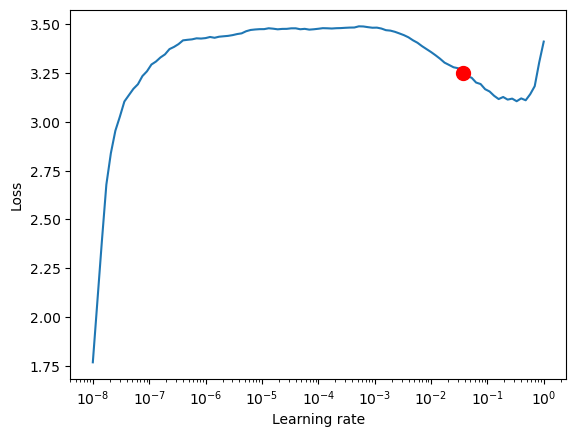

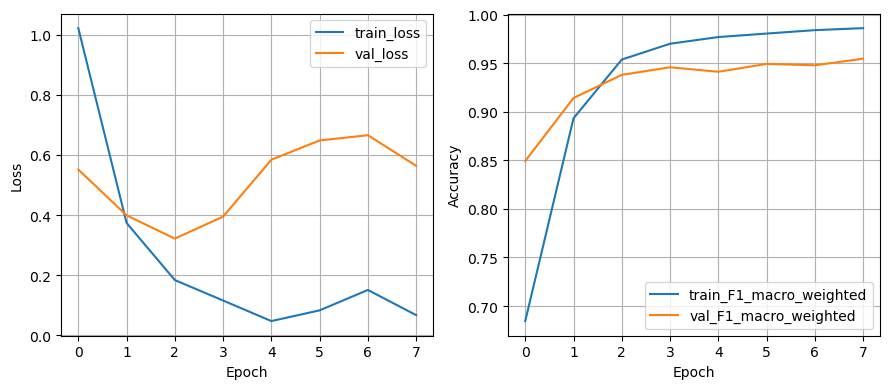

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.9534754753112793     │
└───────────────────────────┴───────────────────────────┘

test_F1_macro_weighted: 0.9534754753112793


In [ ]:
# Define best model
best_params = best_trial.params

# Evaluate best model on test data again
def eval_best_model(best_params, optuna_config):
    # datamodule
    dm=TabularDataModuleClassificationPACKAGING(
        data_dir=f"{config['data_directory']}/output/df_ml.csv",
        continuous_cols=['material_weight'],
        categorical_cols=[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'packaging_code'
        ],
        target=['packaging_category'],
        oversampling=True,
        test_size=0.2,
        val_size=0.2,
        batch_size=best_params['batch_size'],
        SEED=SEED
    )
    dm.prepare_data()
    dm.setup(stage='fit')
    # model
    tabular_data_full = pd.concat([dm.train_dataset.get_dataframe, dm.val_dataset.get_dataframe, dm.test_dataset.get_dataframe], axis=0, ignore_index=True)
    embedding_sizes_cat_features = tl_utils.get_cat_feature_embedding_sizes(tabular_data_full, categorical_cols=dm.categorical_cols)
    best_model = MulticlassTabularCatEmbeddingMLP(
        continuous_cols=dm.continuous_cols,
        categorical_cols=dm.categorical_cols,
        output_size=dm.n_classes,
        hidden_size=best_params['hidden_size'],
        n_hidden_layers=best_params['n_hidden_layers'],
        dropout=best_params['dropout'],
        norm=True,
        embedding_sizes=embedding_sizes_cat_features
    )
    # lightningmodel
    lightningmodel = MulticlassTabularLightningModule(
        model=best_model,
        learning_rate=0.001,
        train_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        val_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        test_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
    )
    # trainer
    trainer = L.Trainer(
        devices="auto", # (os.cpu_count() / 2)
        callbacks=[
            # EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
            ValPercentageEarlyStopping(monitor='val_loss', mode='min', patience=5, min_delta_percentage=0.005),
            ModelCheckpoint(
                monitor="val_loss",
                mode="min",
                save_top_k=1,
                every_n_epochs=1,
                enable_version_counter=False,
                dirpath=f"{config['lightning_exp_storage_directory']}/best_model_checkpoints/{optuna_config['experiment_name']}",
                filename=f"best_model_{optuna_config['experiment_name']}",
            ),
        ],
        logger=CSVLogger(save_dir=f"{config['lightning_exp_storage_directory']}/best_model_checkpoints/csv_logs/", name=optuna_config['experiment_name']),
        max_epochs=100,
        precision='bf16-mixed',
        default_root_dir=f"{config['lightning_exp_storage_directory']}",
    )
    # find learning rate
    tuner = Tuner(trainer)
    lr_finder = tuner.lr_find(lightningmodel, datamodule=dm) # finds learning rate automatically
    new_lr = lr_finder.suggestion()
    fig_lr = lr_finder.plot(suggest=True)
    lightningmodel.learning_rate = new_lr # update hparams of the model
    # train model
    trainer.fit(
        model=lightningmodel,
        train_dataloaders=dm.train_dataloader(),
        val_dataloaders=dm.val_dataloader()
    )
    fig_lr_file_path = f"{config['lightning_exp_storage_directory']}/best_model_checkpoints/{optuna_config['experiment_name']}/learning_rate_best_model_{optuna_config['experiment_name']}.pdf"
    os.makedirs(os.path.dirname(fig_lr_file_path), exist_ok=True)    
    fig_lr.savefig(fig_lr_file_path)
    # plot training metrics
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    tl_utils.plot_training_metrics(metrics)
    # evaluate model on test data
    score = trainer.test(model=lightningmodel, dataloaders=dm.test_dataloader())
    print(f"test_F1_macro_weighted: {score[0]['test_F1_macro_weighted']}")

    return lightningmodel.parameters, lightningmodel.learning_rate

# Evaluate best model on test data
lm_parameters, lm_learning_rate = eval_best_model(best_params, optuna_config)

# Load model from checkpoint, evaluate and make predictions

In [ ]:
def load_model_eval_predict(
    study: optuna.Study = None,
    checkpoint_path: str = None,
) -> None:
    """Loads the best model from the checkpoint and predicts on the test set.
    Args:
        study (optuna.Study): The study object of optuna.
        checkpoint_path (str): The path to the checkpoint.
    Returns:
        None
    """
    # datamodule
    dm=TabularDataModuleClassificationPACKAGING(
        data_dir=f"{config['data_directory']}/output/df_ml.csv",
        continuous_cols=['material_weight'],
        categorical_cols=[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'packaging_code'
        ],
        target=['packaging_category'],
        oversampling=True,
        test_size=0.2,
        val_size=0.2,
        batch_size=best_params['batch_size'],
        SEED=SEED
    )
    dm.prepare_data()
    dm.setup(stage='fit')
    # model
    tabular_data_full = pd.concat([dm.train_dataset.get_dataframe, dm.val_dataset.get_dataframe, dm.test_dataset.get_dataframe], axis=0, ignore_index=True)
    embedding_sizes_cat_features = tl_utils.get_cat_feature_embedding_sizes(tabular_data_full, categorical_cols=dm.categorical_cols)
    best_model = MulticlassTabularCatEmbeddingMLP(
        continuous_cols=dm.continuous_cols,
        categorical_cols=dm.categorical_cols,
        output_size=dm.n_classes,
        hidden_size=best_params['hidden_size'],
        n_hidden_layers=best_params['n_hidden_layers'],
        dropout=best_params['dropout'],
        norm=True,
        embedding_sizes=embedding_sizes_cat_features
    )
    # Parameters that were not tracked (excluded), they need to be provided at the time of loading
    # NOTE: Those parameters are either complicated to track or were excluded to reduce logging of those parameters during training
    lighning_model_args = {
        "model": best_model,
        "learning_rate": study.best_trial.user_attrs["learning_rate"],
        # "train_acc": MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        # "val_acc": MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        # "test_acc": MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
    }
    # lighning_model_args["optimizer"] = torch.optim.Adam  # For compatibility. Not Used
    # lighning_model_args["loss"] = F.cross_entropy  # For compatibility. Not Used
    # lighning_model_args["optimizer_params"] = {}  # For compatibility. Not Used
    # lightning model
    best_trained_lightning_model = MulticlassTabularLightningModule.load_from_checkpoint(
        checkpoint_path=checkpoint_path,
        # map_location=torch.device('cpu'),
        strict=True,
        **lighning_model_args,
    )
    # trainer
    trainer = L.Trainer(
        devices="auto", # (os.cpu_count() / 2)
        callbacks=[
            # EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
            ValPercentageEarlyStopping(monitor='val_loss', mode='min', patience=5, min_delta_percentage=0.005),
        ],
        precision='bf16-mixed',
        default_root_dir=f"{config['lightning_exp_storage_directory']}",
    )
    # predict
    preds_y_test = torch.cat(trainer.predict(model=best_trained_lightning_model, dataloaders=dm.test_dataloader()))
    preds_y_test = dm.label_encoder_target.inverse_transform(preds_y_test.reshape(-1, 1))
    y_test = dm.label_encoder_target.inverse_transform(dm.test_dataset.get_dataframe.iloc[:, -1].values.reshape(-1, 1))
    # calculate classification report
    print(classification_report(y_test, preds_y_test))
    report = classification_report(y_test, preds_y_test, output_dict=True)

    return report, dm, best_trained_lightning_model


# configs to load model from checkpoint
load_config = {
    "experiment_name": model_name,
    "study_storage_directory": config['lightning_exp_storage_directory'],
}
load_config["storage_name"] = f"sqlite:///{load_config['study_storage_directory']}/optuna_storage/{load_config['experiment_name']}.db"

report, dm, best_trained_lightning_model = load_model_eval_predict(
    study=optuna.load_study(study_name=load_config['experiment_name'], storage=load_config["storage_name"]),
    checkpoint_path=f"{config['lightning_exp_storage_directory']}/best_model_checkpoints/{load_config['experiment_name']}/best_model_{load_config['experiment_name']}.ckpt",
)

f1_score = report['accuracy']
f1_macro = report['macro avg']['f1-score']

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

                            precision    recall  f1-score   support

   Blister and Insert Card       0.98      0.93      0.95      1749
  Blister and sealed blist       0.98      0.96      0.97      1582
            Book packaging       1.00      0.80      0.89        20
Cardb. Sleeve w - w/o Shr.       0.41      0.83      0.55       135
  Cardboard hanger w/o bag       0.91      0.85      0.88        80
    Carton cover (Lid box)       0.92      0.70      0.79       130
   Carton tube with or w/o       0.93      0.70      0.80        20
                      Case       0.74      0.87      0.80        97
         Corrugated carton       0.90      0.91      0.91       774
        Countertop display       0.65      0.80      0.72        30
                  Envelope       0.89      0.80      0.84        59
          Fabric packaging       0.91      1.00      0.95        20
            Folding carton       0.98      0.85      0.91      1644
              Hanger/ Clip       0.99      0.97

# Track performance using MLflow

In [ ]:
# NOTE: Change to a meaningful name
EXPERIMENT_NAME = "AutoPackagingCategories"
RUN_NAME = "run_EmbeddingMLP"

with open('../env_vars.yml', 'r') as file:
    env_vars = yaml.safe_load(file)

mlflow_dir = config['mlflow_benchmark_directory']
os.makedirs(mlflow_dir, exist_ok=True)
mlflow.set_tracking_uri("file://" + mlflow_dir)

try:
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    EXPERIMENT_ID = experiment.experiment_id
except AttributeError:
    EXPERIMENT_ID = mlflow.create_experiment(
        EXPERIMENT_NAME,
        # mlflow.set_artifact_uri("file://" + project_dir + "/artifacts/")
    )

current_time = datetime.datetime.now()
time_stamp = str(current_time)
# NOTE: Change to a meaningful name for the single trial
# exp_run_name = f"run_MeaningfulTrialName_{time_stamp}"
exp_run_name = f"{RUN_NAME}_{time_stamp}"

# Start MLflow
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=exp_run_name) as run:

    # Retrieve run id
    RUN_ID = run.info.run_id

    # Track parameters
    # track pipeline configs: preprocessing_pipeline
    mlflow.log_dict(dm.preprocess_pipeline.named_transformers_, "preprocessing_pipeline.json")

    # mode specfic parameters
    {best_trained_lightning_model.model}
    best_trial = study.best_trial
    best_params = best_trial.params
    mlflow.log_param('model', f'{best_trained_lightning_model.model}')
    mlflow.log_param('model_configs', f'{best_params.items()}')
    
    # mode specfic parameters
    
    # Track metrics
    # mlflow.log_metric("Train_f1_macro", train_f1_macro)
    # mlflow.log_metric("TestVal_f1_macro", test_f1_macro)
    mlflow.log_dict(report, "classification_report.json")
    mlflow.log_metric("Report_Test_f1_score", f1_score)
    mlflow.log_metric("Report_Test_f1_macro", f1_macro)

    # Track model
    # mlflow.sklearn.log_model(clf, "classifier")
